### Nama : Jarna Ajda
### kelas : SK5A indralaya
### Nim : 09011181823013

Referensi : https://www.kaggle.com/harisalikhan/hourcsv, https://www.kaggle.com/nguyenhoangtuan/daycsv,                                     https://github.com/shoc2005/back_propagation_ann


# Artificial Neural Network 
# (Jaringan Syaraf Tiruan) 
ANN merupakan sebuah teknik atau pendekatan pengolahan informasi yang terinspirasi oleh cara kerja sistem saraf biologis, khususnya pada sel otak manusia dalam memproses informasi, sebuah neural Network dikonfigurasi untuk aplikasi tertentu, seperti pengenalan pola atau klasifikasi data, dan kemudian disempurnakan melalui proses pembelajaran. Dalam halnya pada Neural Network penyesuaian koneksi sinaptik antar neuron dilakukan dengan menyesuaikan nilai bobot yang ada pada tiap konektivitas baik dari input, neuron maupun output.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Muat dan siapkan datanya

Langkah penting dalam bekerja dengan menggunakan  jaringan neural adalah menyiapkan data dengan benar. Variabel pada skala yang berbeda menyulitkan jaringan untuk mempelajari bobot yang benar secara efisien. Di bawah ini, saya telah menulis kode untuk memuat dan menyiapkan data. Menggunakan dua dataset yairu hour yang terdapat pada folder bernama Bike-Sharing-Dataset

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Memeriksa datanya

Dataset ini memiliki jumlah pengendara untuk setiap jam setiap hari dari 1 Januari 2011 hingga 31 Desember 2012. Jumlah pengendara dibagi antara biasa dan terdaftar, dijumlahkan di kolom `cnt`. Anda dapat melihat beberapa baris pertama dari data di atas.

Di bawah ini adalah plot yang menunjukkan jumlah pengendara sepeda selama 10 hari pertama atau lebih dalam kumpulan data. (Beberapa hari tidak tepat 24 entri dalam kumpulan data, jadi ini tidak tepat 10 hari.) Anda dapat melihat persewaan per jam di sini. Data ini cukup rumit! Akhir pekan memiliki jumlah penumpang yang lebih rendah dan ada lonjakan ketika orang bersepeda ke dan dari tempat kerja selama seminggu. Melihat data di atas, kami juga memiliki informasi tentang suhu, kelembapan, dan kecepatan angin, semua ini kemungkinan memengaruhi jumlah pengendara. 

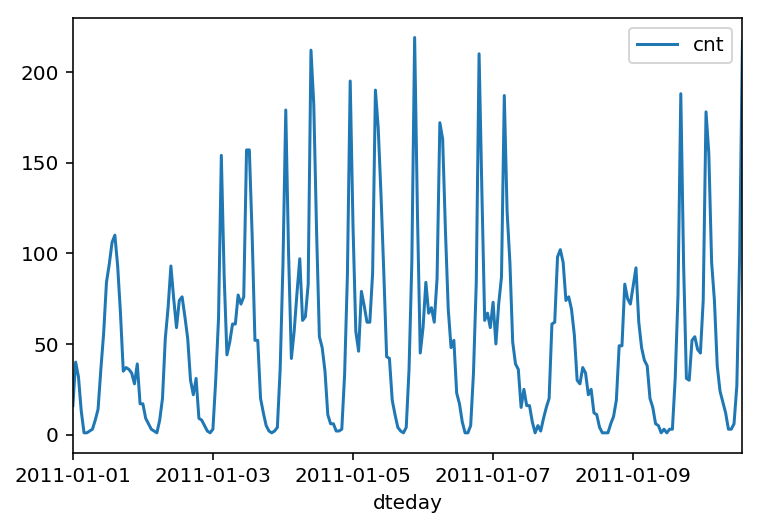

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Variabel Tiruan
Di sini kami memiliki beberapa variabel kategori seperti musim, cuaca, bulan. Untuk memasukkan ini ke dalam model kita, kita perlu membuat variabel dummy biner. Ini mudah dilakukan dengan Pandas  `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Menskalakan Variable target
Untuk membuat pelatihan jaringan lebih mudah, kami akan menstandarkan setiap variabel kontinu. Artinya, kita akan menggeser dan menskalakan variabel sedemikian rupa sehingga variabel tersebut memiliki mean nol dan deviasi standar 1.

Faktor penskalaan disimpan sehingga kita dapat mundur saat menggunakan jaringan untuk prediksi.

In [14]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Memisahkan dat menjadi set pelatihan, pengujian, dan Validasi

saya akan menyimpan data selama sekitar 21 hari terakhir untuk digunakan sebagai set pengujian setelah kami melatih jaringan. Kami akan menggunakan set ini untuk membuat prediksi dan membandingkannya dengan jumlah pengendara sebenarnya.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

Kami akan membagi data menjadi dua set, satu untuk pelatihan dan satu untuk memvalidasi saat jaringan sedang dilatih. Karena ini adalah data deret waktu, kita akan melatih data historis, kemudian mencoba memprediksi data yang akan datang (set validasi).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## membangun jaringan

Di bawah ini Anda akan membangun jaringan. Saya telah membangun strukturnya. Saya akan menerapkan forward pass dan backwards melewati jaringan. Saya juga akan menyetel hyperparameter: kecepatan pembelajaran, jumlah unit tersembunyi, dan jumlah tiket pelatihan.

##### Backpropagation
- mencari lost ke atas(depan)
- mencari bobot ke bawah(belakang)

<img src="Gambar/ArtificialNeuralNetwork.png" width=400px>



Jaringan memiliki dua lapisan, lapisan tersembunyi dan lapisan keluaran. Lapisan tersembunyi akan menggunakan fungsi sigmoid untuk aktivasi. Output layer hanya memiliki satu node dan digunakan untuk regresi, output node sama dengan input node. Artinya, fungsi aktivasi adalah $ f (x) = x $. Suatu fungsi yang menerima sinyal masukan dan menghasilkan sinyal keluaran, tetapi memperhitungkan ambang batas, disebut fungsi aktivasi. Kami bekerja melalui setiap lapisan jaringan kami menghitung keluaran untuk setiap neuron. Semua keluaran dari satu lapisan menjadi masukan ke neuron di lapisan berikutnya. Proses ini disebut *forward propagation*.

Kami menggunakan bobot untuk menyebarkan sinyal ke depan dari lapisan masukan ke keluaran dalam jaringan neural. Kami menggunakan bobot untuk juga menyebarkan kesalahan mundur dari keluaran kembali ke jaringan untuk memperbarui bobot kami. Ini disebut *backpropagation*.

> **Petunjuk:** Saya akan membutuhkan turunan dari fungsi aktivasi keluaran ($ f (x) = x $) untuk implementasi backpropagation. fungsi ini setara dengan persamaan $ y = x $. Berapakah kemiringan persamaan itu? Itu adalah turunan dari $ f (x) $.

Dibawah ini tugas-tugasnya:
1. Menerapkan fungsi sigmoid untuk digunakan sebagai fungsi aktivasi. Set `self.activation_function` in `__init__` ke fungsi sigmoid
2. Terapkan forward pass di `train` method.
3. Menerapkan algoritma backpropagation di file `train` method, termasuk menghitung kesalahan keluaran.
4. terapkan forward pass di `run` method.
  

In [9]:
from my_answers import NeuralNetwork

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Tes Unit

menjalankan pengujian unit ini untuk memeriksa kebenaran implementasi jaringan Anda. Ini akan membantu saya memastikan jaringan yang saya terapkan yaitu dengan benar sebelum saya mulai mencoba melatihnya.

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
   
    # Tes unit untuk pemuatan data
    
    def test_data_path(self):
        # Uji bahwa jalur file ke set data tidak berubah
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Uji bahwa Frame data dimuat
        self.assertTrue(isinstance(rides, pd.DataFrame))
    

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Uji apakah fungsi aktivasi adalah sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Uji apakah bobot diperbarui dengan benar pada pelatihan
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # TUji kebenaran run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.202s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Di sini Saya akan mengatur hyperparameter untuk jaringan. Strateginya di sini adalah menemukan hyperparameter sedemikian rupa sehingga kesalahan pada set pelatihan rendah, tetapi Saya tidak overfitting ke data. Jika saya melatih jaringan terlalu lama atau memiliki terlalu banyak node tersembunyi, ini bisa menjadi terlalu spesifik untuk set pelatihan dan akan gagal untuk menggeneralisasi set validasi. Artinya, kerugian pada set validasi akan mulai meningkat saat kerugian set pelatihan turun.

Saya juga akan menggunakan metode yang dikenal sebagai Stochastic Gradient Descent (SGD) untuk melatih jaringan. Idenya adalah bahwa untuk setiap tiket pelatihan, Saya mengambil sampel data secara acak alih-alih menggunakan seluruh kumpulan data. Saya menggunakan lebih banyak kartu pelatihan dibandingkan dengan penurunan gradien normal, tetapi setiap langkah akan jauh lebih cepat. Ini akhirnya melatih jaringan dengan lebih efisien. 

### Pilih jumlah iterasi
Ini adalah jumlah batch sampel dari data pelatihan yang akan kami gunakan untuk melatih jaringan. Semakin banyak iterasi yang Anda gunakan, semakin baik modelnya sesuai dengan datanya. Namun, proses ini dapat memiliki hasil yang sangat berkurang dan dapat membuang sumber daya komputasi jika Anda menggunakan terlalu banyak iterasi. Anda ingin menemukan angka di sini di mana jaringan memiliki kerugian pelatihan yang rendah, dan kerugian validasinya minimal. Jumlah iterasi yang ideal adalah level yang berhenti segera setelah kerugian validasi tidak lagi menurun.

### Pilih kecepatan Learning
Ini menskalakan pembaruan ukuran berat. Jika ini terlalu besar, bobotnya cenderung meledak dan jaringan gagal menyesuaikan data. Biasanya pilihan yang baik untuk memulai adalah 0,1; namun, jika Anda membagi kecepatan pemelajaran secara efektif dengan n_records, coba mulai dengan kecepatan pemebelajaran 1. Dalam kedua kasus, jika jaringan mengalami masalah saat menyesuaikan data, coba kurangi kecepatan pemelajaran. Perhatikan bahwa semakin rendah kecepatan pemelajaran, semakin kecil langkah-langkahnya dalam pembaruan bobot dan semakin lama waktu yang dibutuhkan jaringan neural untuk berkumpul.

### Pilih jumlah hidden nodes
Dalam model yang semua bobotnya dioptimalkan, semakin banyak node tersembunyi yang Anda miliki, semakin akurat prediksi model tersebut. (Model yang sepenuhnya dioptimalkan bisa saja memiliki bobot nol.) Namun, semakin banyak node tersembunyi yang Anda miliki, semakin sulit untuk mengoptimalkan bobot model, dan semakin besar kemungkinan bobot suboptimal akan menghasilkan overfitting. Dengan overfitting, model akan menghafal data pelatihan daripada mempelajari pola yang sebenarnya, dan tidak akan menggeneralisasi dengan baik ke data yang tidak terlihat.  

Coba beberapa angka berbeda dan lihat bagaimana pengaruhnya terhadap kinerja. Anda dapat melihat losses dictionary untuk metrik kinerja jaringan. Jika jumlah unit tersembunyi terlalu rendah, model tidak akan memiliki cukup ruang untuk belajar dan jika terlalu tinggi, terlalu banyak pilihan arah yang dapat diambil pembelajaran. Triknya di sini adalah menemukan keseimbangan yang tepat dalam jumlah unit tersembunyi yang Anda pilih. Anda biasanya akan menemukan bahwa jumlah terbaik dari node tersembunyi untuk digunakan akhirnya berada di antara jumlah node input dan output.

In [12]:
import sys


from my_answers import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
  
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


Progress: 100.0% ... Training loss: 0.065 ... Validation loss: 0.141

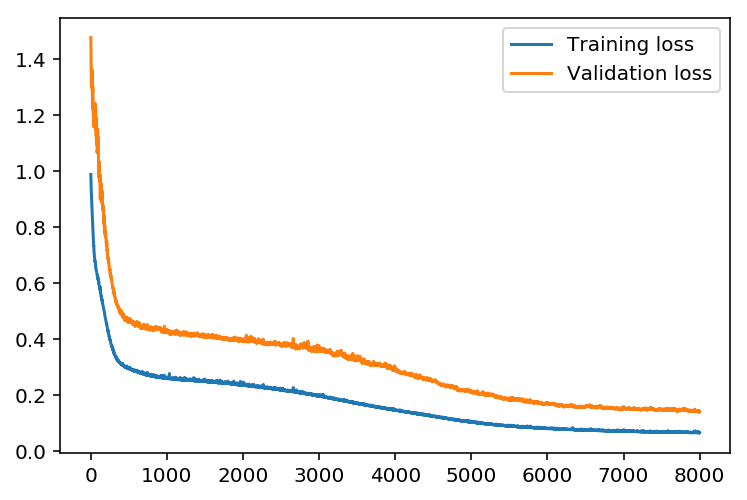

In [13]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Lihat Prediksi

Di sini, gunakan data pengujian untuk melihat seberapa baik jaringan Anda memodelkan data. Jika ada yang salah di sini, pastikan setiap langkah di jaringan yang diterapkan dengan benar.

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


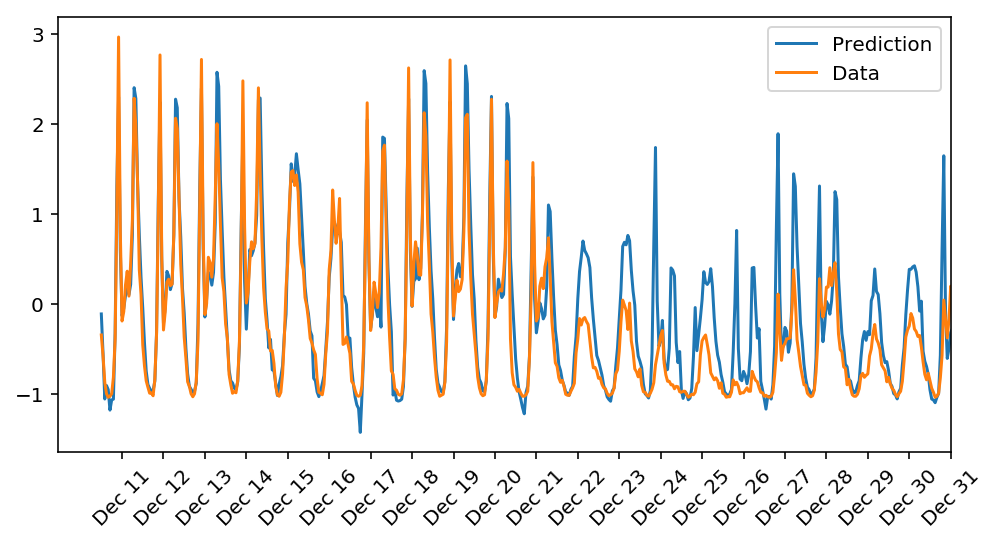

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

In [16]:
import numpy as np


class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### Setel self.activation_function ke fungsi sigmoid yang di implementasikan ####
        #
        # Catatan: dengan Python, Anda dapat mendefinisikan fungsi dengan ekspresi lambda,
        # seperti yang ditunjukkan di bawah ini
        self.activation_function = lambda x : 1.0 / (1.0 + np.exp(-x))  
        # Gantikan 0 dengan perhitungan sigmoid 
        
                   

    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        for X, y in zip(features, targets):
            
            final_outputs, hidden_outputs = self.forward_pass_train(X)  
            
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):
        ''' Implement forward pass here 
         
            Arguments
            ---------
            X: features batch

        '''
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer - Replace these values with your calculations.
        hidden_inputs = np.matmul(X, self.weights_input_to_hidden) # signals into hidden layer
                
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # TODO: Output layer - Replace these values with your calculations.
        final_inputs = np.matmul(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs.copy() # signals from final output layer
        
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Implement backpropagation
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        #### Implement the backward pass here ####
        ### Backward pass ###

        # TODO: Output error - Replace this value with your calculations.
        error = y - final_outputs
        
        # TODO: Calculate the hidden layer's contribution to the error
        hidden_error = error * self.weights_hidden_to_output
        hidden_error = hidden_error.reshape(hidden_error.shape[0])
        # Backpropagated error terms - Gantikan nilai-nilai ini dengan perhitungan.
        output_error_term = error.copy()
                      
        hidden_error_term = (hidden_outputs * (1 - hidden_outputs))
        #print("hidden_error_term shape", hidden_error_term.shape)
        hidden_error_term = hidden_error_term * hidden_error
        #print("hidden_error shape", hidden_error.shape)
        #print("hidden_error_term shape", hidden_error_term.shape)
        #print("hidden_outputs shape", hidden_outputs.shape)
        # Weight step (input to hidden)
        delta_weights_i_h += self.lr * hidden_error_term * X[:,None]
        #print("delta_weights_i_h shape", delta_weights_i_h.shape)
        #print("output_error_term shape", output_error_term.shape)
        #print("delta_weights_h_o shape", delta_weights_h_o.shape)
        # Weight step (hidden untuk output)
        h_o = self.lr * output_error_term  * hidden_outputs
        #print(self.lr, output_error_term, hidden_outputs, h_o[None,:], delta_weights_h_o)
        delta_weights_h_o += h_o[:,None] # learnrate * output_error_term * hidden_layer_output
        
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records

        '''
        self.weights_hidden_to_output += delta_weights_h_o / float(n_records)
        self.weights_input_to_hidden += delta_weights_i_h / float(n_records) 

    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        # Menerapkan forward pass disini#
        # TODO: Hidden layer - Gantikan nilai dengan kalkulasi yang sesuai.
        hidden_inputs = np.matmul(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # Output layer - Gantikan nilai ini dengan kalkulasi yang sesuai.
        final_inputs = np.matmul(hidden_outputs, self.weights_hidden_to_output) # sinyal ke akhir output layer
        final_outputs = final_inputs.copy() # signal akhir output layer 
        
        return final_outputs



# Setel hyperparameter di sini

iterations = 8000
learning_rate = 0.25
hidden_nodes = 6
output_nodes = 1

### Activation Function : Sigmoid (logistic function)
Sigmoid function dikenal juga dengan instilah logistic function, akan menghasilkan nilai pada rentang [0 , 1], dirumuskan sebagai,!

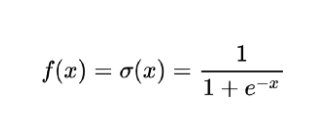

Pada mulanya fungsi sigmoid tumbuh secara exponenial, setelah itu mulai terjadi saturasi dan pertumbuhan melambat sehingga menjadi linear sampai pertumbuhan berhenti. Kurva Sigmoid function digambarkan sebagai berikut,

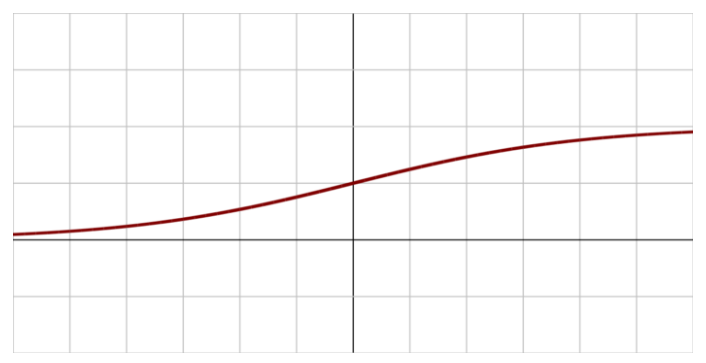

#### Backpropagation (rumusnya):
Rumus utama untuk memperbaiki suatu bobot w berdasarkan error E adalah:
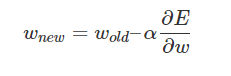
Rumus ini juga berlaku untuk memperbaiki nilai bias:
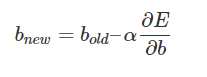
            Simbol α pada rumus di atas adalah learning rate, sebuah konstanta (biasanya antara 0-1) yang menentukan seberapa cepat proses pembelajaran model dilakukan. Di artikel ini kita akan menggunakan nilai α=0.5. Sedangkan simbol ∂E/∂w atau dibaca “turunan parsial E terhadap w” adalah proses mencari nilai turunan E terhadap variabel yang akan diperbarui, dalam contoh ini w. Proses mencari turunan inilah yang lebih tepat disebut backpropagation. Karena ada banyak nilai w, kita akan spesifikkan untuk mengupdate nilai w11 terlebih dulu. Setelahnya, kita akan coba hitung update nilai untuk b1.